# Fish Classifier

This notebook does the classification on the fish given the annotations. 

As we can perturb the images however we want without affecting the class, the code used here will be much simpler and much more concise. Let's begin by reading in the merged annotation data.

In [1]:
%matplotlib inline

# system libraries
import os
from glob import glob
import logging

# numerical,image and plotting stuff
import math
import pandas as pd
import numpy as np
from PIL import Image
from skimage import io
import skimage.transform as tf
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

# read in df_full (prepared from previous ipynb)
df = pd.read_csv('data/df.csv')
markers1 = pd.read_csv('data/markers1.csv').dropna()
df_full = pd.merge(left=df,right=markers1,how='left',left_on='fname',right_on='filename')
df_full = df_full[(df_full.category == 'NoF') | ((df_full.category != 'NoF') & (~df_full.head_x.isnull()))]
print(len(df_full))
df_full.head()

3767


,fpath,h,w,category,fname,filename,head_x,head_y,tail_x,tail_y
0,data/train/ALB/img_00003.jpg,720,1280,ALB,img_00003.jpg,img_00003.jpg,825.5,342.8,1095.1,449.4
1,data/train/ALB/img_00010.jpg,720,1280,ALB,img_00010.jpg,img_00010.jpg,721.6,606.1,688.1,433.6
2,data/train/ALB/img_00012.jpg,974,1280,ALB,img_00012.jpg,img_00012.jpg,492.2,514.0,602.7,681.4
3,data/train/ALB/img_00015.jpg,750,1280,ALB,img_00015.jpg,img_00015.jpg,258.0,359.6,435.7,396.2
4,data/train/ALB/img_00019.jpg,720,1280,ALB,img_00019.jpg,img_00019.jpg,165.0,459.3,284.3,415.5


## Data Prep

Let's write a generator that will generate cropped images of a fish given it's row in `df_full`, with some affine transformation. We pick a random annotation here for demonstrating the logic.

data/train/YFT/img_04472.jpg fpath       data/train/YFT/img_04472.jpg
h                                    720
w                                   1280
category                             YFT
fname                      img_04472.jpg
filename                   img_04472.jpg
head_x                             446.8
head_y                             469.5
tail_x                             621.3
tail_y                             485.1
Name: 3462, dtype: object
175.1959189022392 -174.89143623422024


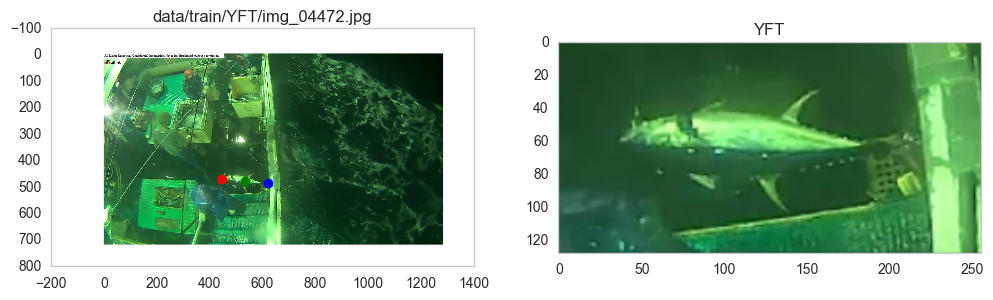

In [2]:
m_coord = None

# randomly pick an annotation
rng = np.random.RandomState()
random_ix = int(np.round(rng.uniform(0,1,1)[0]*len(df_full)))
annotation = df_full.iloc[random_ix]

# calculate annotation params from data frame
fpath = annotation['fpath']
fish_type = annotation['category']
img = io.imread(fpath)
h, w, _ = img.shape
h_out,w_out = 128,256

# plot original picture
f = plt.figure(figsize=(12,10))
plt.subplot(121)
plt.title(fpath)
plt.imshow(img)

if fish_type == 'NoF':
    # if NoF, pick a random block in the image
    x_start, y_start = int(rng.uniform(w-w_out-1)), int(rng.uniform(h-h_out-1))
    img_resized = img[y_start:(y_start+h_out),x_start:(x_start+w_out),:]
elif m_coord:
    raise NotImplementedError
    # TODO get hx,hy,tx,ty from m_coord if available:
else:
    hx,hy,tx,ty = annotation[['head_x','head_y','tail_x','tail_y']]

    mx, my = (hx+tx)/2, (hy+ty)/2
    hypot = math.hypot(hx-tx, hy-ty)
    angle = math.atan2(hy-ty, hx-tx)
    h_cropped, w_cropped = hypot/2, hypot
    h_out, w_out = 128, 256
    h_buffer, w_buffer = rng.uniform(10,20,1),rng.uniform(30,50,1)

    # print results and plot annotations
    print(fpath,annotation)
    print(hypot,angle/math.pi*180)
    plt.plot(hx,hy,'ro')
    plt.plot(mx,my,'go')
    plt.plot(tx,ty,'bo')

    # prepare transformations
    tf_shift = tf.SimilarityTransform(translation=[-mx+rng.uniform(-10,10,1), -my+rng.uniform(-10,10,1)])
    tf_shift_inv = tf.SimilarityTransform(translation=[(w_cropped+w_buffer)/2, (h_cropped+h_buffer)/2])
    tf_rotate = tf.SimilarityTransform(rotation=math.pi-angle)
    tf_scale = tf.SimilarityTransform(scale=rng.uniform(0.8,1,1))
    tf_shear = tf.AffineTransform(shear=rng.uniform(-0.1,0.1,1))
    trans = tf_shift + tf_scale + tf_shear + tf_rotate + tf_shift_inv

    img_warped = tf.warp(img, trans.inverse)
    img_cropped = img_warped[:int(h_cropped+h_buffer),:int(w_cropped+w_buffer),:]
    img_resized = tf.resize(img_cropped,(h_out,w_out))

# plot cropped image
plt.subplot(122)
plt.imshow(img_resized)
plt.title(fish_type)

In [3]:

# read, and crop image
def read_and_crop(annotation,h_out=128,w_out=256,rng=None,m_coord=None):
    
    if rng is None:
        rng = np.random.RandomState()
    
    # calculate annotation params from data frame
    fpath = annotation['fpath']
    fish_type = annotation['category']
    img = io.imread(fpath)
    h, w, _ = img.shape
    if fish_type == 'NoF':
        # if NoF, pick a random block in the image
        x_start, y_start = int(rng.uniform(w-w_out-1)), int(rng.uniform(h-h_out-1))
        img_resized = img[y_start:(y_start+h_out),x_start:(x_start+w_out),:]/255.
    elif m_coord:
        raise NotImplementedError
        # get hx,hy,tx,ty from m_coord if available:
    else:
        hx,hy,tx,ty = annotation[['head_x','head_y','tail_x','tail_y']]
        mx, my = (hx+tx)/2, (hy+ty)/2
        hypot = math.hypot(hx-tx, hy-ty)
        angle = math.atan2(hy-ty, hx-tx)
        h_cropped, w_cropped = hypot/2, hypot
        h_buffer, w_buffer = rng.uniform(10,20,1),rng.uniform(30,50,1)

        # prepare transformations
        tf_shift = tf.SimilarityTransform(translation=[-mx+rng.uniform(-20,20,1), -my+rng.uniform(-20,20,1)])
        tf_shift_inv = tf.SimilarityTransform(translation=[(w_cropped+w_buffer)/2, (h_cropped+h_buffer)/2])
        tf_rotate = tf.SimilarityTransform(rotation=math.pi-angle)
        tf_scale = tf.SimilarityTransform(scale=rng.uniform(0.8,1,1))
        tf_shear = tf.AffineTransform(shear=rng.uniform(-0.1,0.1,1))
        trans = tf_shift + tf_scale + tf_shear + tf_rotate + tf_shift_inv

        img_warped = tf.warp(img, trans.inverse)
        img_cropped = img_warped[:int(h_cropped+h_buffer),:int(w_cropped+w_buffer),:]
        img_resized = tf.resize(img_cropped,(h_out,w_out))
        
        # randomly flip vertically
        if rng.uniform(0,1) < 0.5:
            img_resized = img_resized[::-1,:,:]

    return img_resized


def gen(fishes, batch_size=32, rng=None,h_out=128,w_out=256,ch_out=3, ohc=None):
    """
    This generator produces a batch of (X,y) for training a fish detector.
    Images are randomly augmented.
    
    Inputs:
    fishes is a pandas dataframe containing the file path (fpath), 
    width, height, head and tail annotations
    
    Outputs:
    X is a 4D tensor of shape (batch_size,h,w,ch)
    y is a 2D vector of (batch_size,8), for the 8 classes
    """

    if rng is None:
        rng = np.random.RandomState()
    if ohc is None:
        ohc = LabelBinarizer()
        ohc.fit(df_full['category'])
    n = len(fishes)
    total_batch = int(np.ceil(n / batch_size))
    logging.info('generating %d batches with %d samples per epoch' % (total_batch,n))
    
    while True:
        # shuffle examples every epoch
        fishes_shuffled = fishes.iloc[rng.permutation(n)]
        for i_batch in range(total_batch):
            # limit end index by size of df_gen to prevent 
            # indexing up to the next multiple of batch_size
            i_start, i_end = i_batch * batch_size, min((i_batch + 1) * batch_size,n)
            i_batch_size = i_end - i_start
            X = np.zeros((i_batch_size,h_out,w_out,ch_out))
            Y = np.zeros((i_batch_size,8))
            for i in range(i_start,i_end):
                annotation = fishes_shuffled.iloc[i]
                x = read_and_crop(annotation,h_out,w_out,rng) # read and augment image
                i_intrabatch = i - i_start
                X[i_intrabatch,...] = x
            Y = ohc.transform(fishes_shuffled.iloc[i_start:i_end]['category'])
            logging.info('yielding batch %d of size %d' % (i_batch, i_batch_size))
            yield(X,Y)

In [5]:
bs = 6
dg = gen(df_full,batch_size=bs)
ohc = LabelBinarizer()
ohc.fit(df_full['category'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

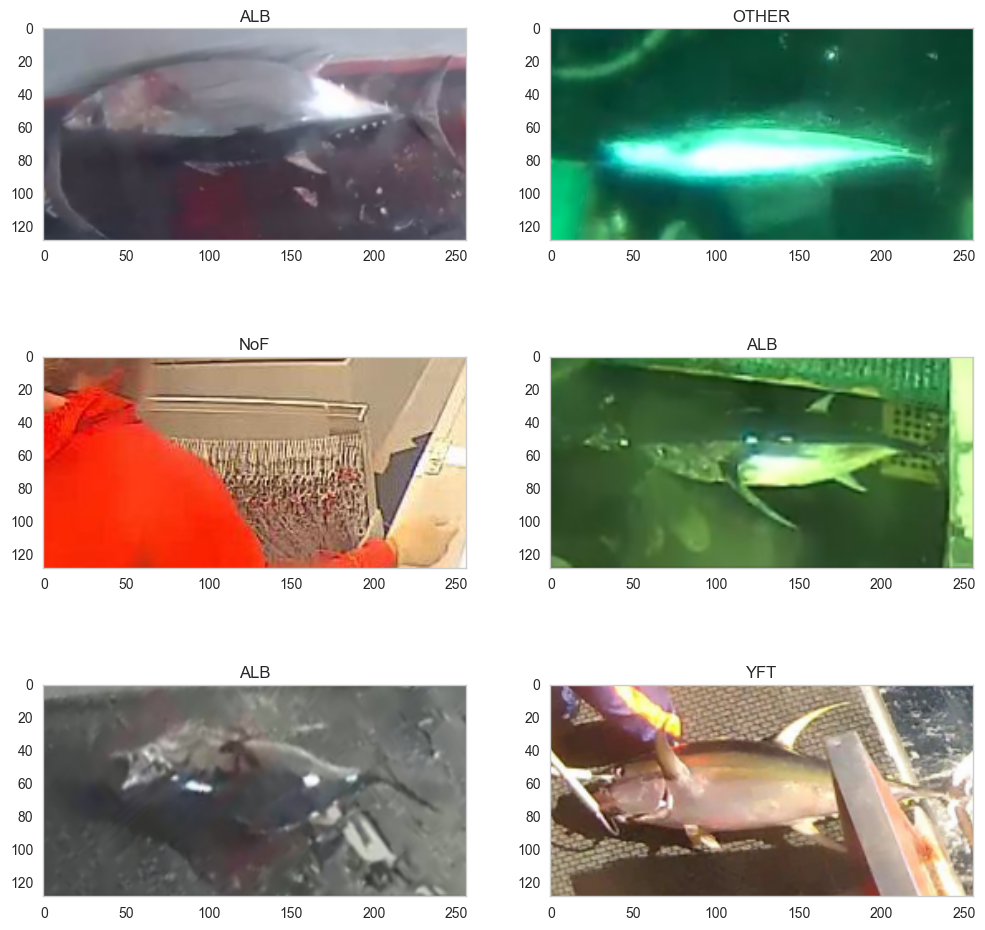

In [6]:

X,Y = next(dg)

lab = ohc.inverse_transform(Y) # fit ohc
plt.figure(figsize=(12,bs*2))
for i in range(bs):
    plt.subplot(bs/2,2,i+1)
    plt.imshow(X[i,...])
    plt.title(lab[i])

In [ ]:
# initialize generators
rng = np.random.RandomState(290615)

# we just use train valid test for training our model
ix_coord = rng.choice(range(3),p=[0.8,0.1,0.1],size=len(df_full))
df_train = df_full.ix[ix_coord==0]
df_valid = df_full.ix[ix_coord==1]
df_test = df_full.ix[ix_coord==2]
gn_train = gen(df_train,batch_size=64,rng=np.random.RandomState(290615),h_out=128,w_out=256,ohc=ohc)
gn_valid = gen(df_valid,batch_size=64,rng=np.random.RandomState(290615),h_out=128,w_out=256,ohc=ohc)
samples_per_epoch = len(df_train)
nb_val_samples = len(df_valid)


## Model

With the data generator in place, we proceed to train our model using weights from a pre-trained net

In [ ]:
from keras.layers import Input, Convolution2D, MaxPooling2D, ZeroPadding2D, Layer,\
    Activation, Dropout, Flatten, MaxoutDense, Dense, merge
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

# setup model
h_out, w_out = 128, 256

# creates a residual block
def res_block(input_layer,depth,layer_number):
    # skip bn-relu for first layer (0-indexed here)
    if layer_number > 0:
        bn = BatchNormalization()(input_layer)
        bn_relu = Activation('relu')(bn)
    else:
        bn_relu = input_layer
    bn_relu_conv = Convolution2D(depth,3,3,name='conv'+str(layer_number)+'_1',
                               border_mode='same',W_regularizer=l2(0.0001))(bn_relu)
    bn_relu_conv_bn = BatchNormalization()(bn_relu_conv)
    bn_relu_conv_bn_relu = Activation('relu')(bn_relu_conv_bn)
    bn_relu_conv_bn_relu_conv = Convolution2D(depth,3,3,name='conv'+str(layer_number)+'_2',
                               border_mode='same',W_regularizer=l2(0.0001))(bn_relu_conv_bn_relu)
    residual = Convolution2D(depth,1,1,name='resid'+str(layer_number),border_mode='same',
                             W_regularizer=l2(0.0001))(input_layer)
    merged = merge([bn_relu_conv_bn_relu_conv,residual],mode='sum')
    merged_pool = MaxPooling2D((2,2),strides=(2,2))(merged)
    return merged_pool


def new_model(h_in=128, w_in=256 ,ch=3):
    
    image_input = Input(shape=(h_in,w_in,ch))

    res1_out = res_block(image_input,16,0)
    res2_out = res_block(res1_out,32,1)
    res3_out = res_block(res2_out,64,2)
    res4_out = res_block(res3_out,128,3)
    res5_out = res_block(res4_out,128,4)
    post_conv_flat = Flatten()(res5_out)
    
    post_conv_flat = Dense(2048, activation='relu', init='glorot_normal')(post_conv_flat)
    post_conv_flat = Dropout(0.3)(post_conv_flat)
    post_conv_flat = Dense(2048, activation='relu', init='glorot_normal')(post_conv_flat)
    post_conv_flat = Dropout(0.2)(post_conv_flat)
    predictions = Dense(8, activation='softmax', init='glorot_normal')(post_conv_flat)
    
    model = Model(input=[image_input],output=[predictions])
    return model

model = new_model()
adam = Adam(lr=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# setup tensorboard graph directory
graph_dir = 'graph/graph_classify'
if not os.path.exists(graph_dir):
    os.makedirs(graph_dir)

# prepare callbacks
tb = TensorBoard(log_dir=graph_dir, write_graph=True, write_images=True)
mc_coord = ModelCheckpoint(filepath='models/classifier_ep{epoch:02d}_loss{val_loss:.2f}_acc{val_accuracy:.2f}.h5',
                           verbose=1,save_best_only=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, 
                             verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=1e-7)


model.fit_generator(generator=gn_train,
                        samples_per_epoch=samples_per_epoch,
                        validation_data=gn_valid,
                        nb_val_samples=nb_val_samples,
                        nb_epoch=500,
                        callbacks=[tb,mc_coord,reducelr])

Using TensorFlow backend.


Epoch 1/500
